In [1]:
import torchvision

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [3]:
import torch

In [4]:
from torchvision import datasets, models

In [5]:
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [7]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cpu
0.20.1+cpu


In [8]:
# our dataset is in cocoformat, we will need pypcoco tools
from pycocotools.coco import COCO

In [9]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [10]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [11]:
data_path = r'..\data'

In [12]:
data_path

'..\\data'

In [13]:
#load classes
coco = COCO(os.path.join(data_path, "train", "_annotations.coco.json"))

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [14]:
categories = coco.cats
n_classes = len(categories.keys())
categories

{0: {'id': 0, 'name': 'rider-helmet-bike', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'With Helmet', 'supercategory': 'rider-helmet-bike'},
 2: {'id': 2, 'name': 'Without Helmet', 'supercategory': 'rider-helmet-bike'}}

In [16]:
classes = [item['name'] for key, item in categories.items()]
classes

['rider-helmet-bike', 'With Helmet', 'Without Helmet']

In [17]:
len(classes)

3

In [23]:
coco = COCO(os.path.join(data_path, 'train', "_annotations.coco.json")) # annotatiosn stored here

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [25]:
coco

In [24]:
ids = list(sorted(coco.imgs.keys()))

In [27]:
ids[:5]

[0, 1, 2, 3, 4]

In [29]:
ids = [id for id in ids if (len(coco.loadAnns(coco.getAnnIds(id))) > 0)] # get annotatiosn and load them

In [31]:
ids[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [33]:
id =0

In [34]:
path = coco.loadImgs(id)[0]['file_name']

In [35]:
path

'BikesHelmets605_png_jpg.rf.62b28e9a26ac0d500429684cf128901d.jpg'

In [36]:
image = cv2.imread(os.path.join(data_path, 'train', path))

In [37]:
image

array([[[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [234, 239, 240],
        [245, 243, 243],
        [236, 231, 232]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [221, 226, 227],
        [231, 233, 233],
        [239, 237, 237]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [210, 220, 220],
        [219, 224, 225],
        [234, 238, 239]],

       ...,

       [[ 12,  18,  25],
        [ 14,  20,  27],
        [ 15,  21,  28],
        ...,
        [ 91,  96,  99],
        [ 91,  96,  99],
        [ 92,  97, 100]],

       [[ 12,  18,  25],
        [ 14,  20,  27],
        [ 15,  21,  28],
        ...,
        [ 90,  95,  98],
        [ 89,  94,  97],
        [ 88,  93,  96]],

       [[ 12,  18,  25],
        [ 14,  20,  27],
        [ 15,  21,  28],
        ...,
        [ 90,  95,  98],
        [ 88,  93,  96],
        [ 86,  91,  94]]

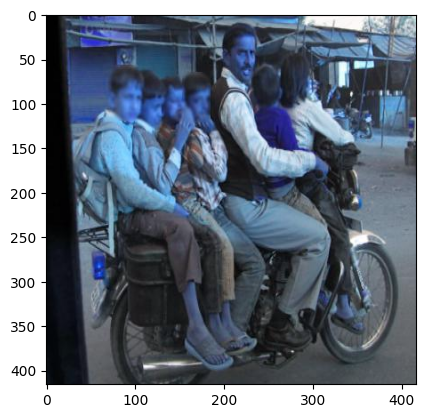

In [38]:
plt.imshow(image)

In [39]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

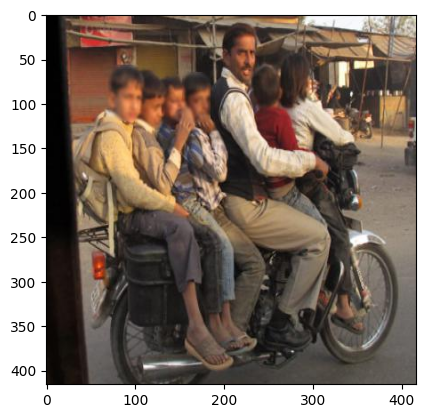

In [40]:
plt.imshow(image)

In [46]:
index = 0

In [47]:
id = ids[index]

In [48]:
id

0

In [49]:
target = coco.loadAnns(coco.getAnnIds(id))

In [50]:
target  # for seven person in this image

[{'id': 0,
  'image_id': 0,
  'category_id': 2,
  'bbox': [70, 57, 38, 64],
  'area': 2432,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 1,
  'image_id': 0,
  'category_id': 2,
  'bbox': [100, 60, 36, 69.5],
  'area': 2502,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 2,
  'image_id': 0,
  'category_id': 2,
  'bbox': [130, 68, 26.5, 54],
  'area': 1431,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 3,
  'image_id': 0,
  'category_id': 2,
  'bbox': [153, 66, 33, 58],
  'area': 1914,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 4,
  'image_id': 0,
  'category_id': 2,
  'bbox': [198, 6, 37, 72],
  'area': 2664,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 5,
  'image_id': 0,
  'category_id': 2,
  'bbox': [230, 54, 36, 53.5],
  'area': 1926,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 6,
  'image_id': 0,
  'category_id': 2,
  'bbox': [264, 44, 34.5, 55],
  'area': 1897.5,
  'segmentation': [],
  'iscrowd': 0}]

In [ ]:
# Shallow Copy vs Deep Copy
# A shallow copy constructs a new compound object and then (to the extent possible) inserts references into it to the objects found in the original. This means that if you modify a sub-object of the original, the same modification will be reflected in the copy.
# A deep copy, on the other hand, constructs a new compound object and then, recursively, inserts copies into it of the objects found in the original. This means that if you modify a sub-object of the original, the same modification will not be reflected in the copy.

In [ ]:
# import copy

# original_list = [[1, 2], [3, 4]]

# # Shallow copy
# shallow_copy = copy.copy(original_list)

# # Deep copy
# deep_copy = copy.deepcopy(original_list)

# # Modify the original list
# original_list.append([5, 6])
# original_list[0][0] = 'X'

# print("Original List:", original_list)
# print("Shallow Copy:", shallow_copy)
# print("Deep Copy:", deep_copy)

# Original List: [['X', 2], [3, 4], [5, 6]]
# Shallow Copy: [['X', 2], [3, 4]]
# Deep Copy: [[1, 2], [3, 4]]

In [51]:
target = copy.deepcopy(target)

In [52]:
target # for seven person in this image

[{'id': 0,
  'image_id': 0,
  'category_id': 2,
  'bbox': [70, 57, 38, 64],
  'area': 2432,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 1,
  'image_id': 0,
  'category_id': 2,
  'bbox': [100, 60, 36, 69.5],
  'area': 2502,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 2,
  'image_id': 0,
  'category_id': 2,
  'bbox': [130, 68, 26.5, 54],
  'area': 1431,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 3,
  'image_id': 0,
  'category_id': 2,
  'bbox': [153, 66, 33, 58],
  'area': 1914,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 4,
  'image_id': 0,
  'category_id': 2,
  'bbox': [198, 6, 37, 72],
  'area': 2664,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 5,
  'image_id': 0,
  'category_id': 2,
  'bbox': [230, 54, 36, 53.5],
  'area': 1926,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 6,
  'image_id': 0,
  'category_id': 2,
  'bbox': [264, 44, 34.5, 55],
  'area': 1897.5,
  'segmentation': [],
  'iscrowd': 0}]

In [53]:
boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations

In [54]:
boxes # for seven person in this image

[[70, 57, 38, 64, 2],
 [100, 60, 36, 69.5, 2],
 [130, 68, 26.5, 54, 2],
 [153, 66, 33, 58, 2],
 [198, 6, 37, 72, 2],
 [230, 54, 36, 53.5, 2],
 [264, 44, 34.5, 55, 2]]

In [55]:
transformer_obj = get_transforms(True)

In [56]:
transformer_obj

Compose([
  Resize(p=1.0, height=600, width=600, interpolation=1, mask_interpolation=0),
  HorizontalFlip(p=0.3),
  VerticalFlip(p=0.3),
  RandomBrightnessContrast(p=0.1, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True, ensure_safe_range=False),
  ColorJitter(p=0.1, brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.5, 0.5)),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'coco', 'label_fields': None, 'min_area': 0.0, 'min_visibility': 0.0, 'min_width': 0.0, 'min_height': 0.0, 'check_each_transform': True, 'clip': False}, keypoint_params=None, additional_targets={}, is_check_shapes=True)

In [57]:
transformed = transformer_obj(image=image, bboxes=boxes)

In [58]:
transformed

{'image': tensor([[[  0,   0,   0,  ..., 254, 249, 242],
          [  0,   0,   0,  ..., 248, 248, 246],
          [  0,   0,   0,  ..., 241, 246, 249],
          ...,
          [ 20,  21,  22,  ..., 100,  99,  99],
          [ 20,  21,  22,  ...,  99,  98,  97],
          [ 20,  21,  22,  ...,  98,  97,  96]],
 
         [[  0,   0,   0,  ..., 254, 253, 248],
          [  0,   0,   0,  ..., 247, 249, 250],
          [  0,   0,   0,  ..., 237, 244, 250],
          ...,
          [  9,   9,  10,  ...,  92,  92,  92],
          [  9,   9,  10,  ...,  92,  91,  90],
          [  9,   9,  10,  ...,  91,  90,  89]],
 
         [[  0,   0,   0,  ..., 254, 251, 246],
          [  0,   0,   0,  ..., 248, 248, 247],
          [  0,   0,   0,  ..., 241, 245, 249],
          ...,
          [ 24,  25,  26,  ..., 101, 100, 100],
          [ 24,  25,  26,  ..., 100,  99,  98],
          [ 24,  25,  26,  ...,  99,  98,  97]]], dtype=torch.uint8),
 'bboxes': [[100.96154022216797,
   82.21154022216797,

In [59]:
image = transformed['image']
boxes = transformed['bboxes']

In [60]:
new_boxes = [] # convert from xywh to xyxy
for box in boxes:
    xmin = box[0]
    xmax = xmin + box[2]
    ymin = box[1]
    ymax = ymin + box[3]
    new_boxes.append([xmin, ymin, xmax, ymax])

In [61]:
new_boxes

[[100.96154022216797,
  82.21154022216797,
  155.76923751831055,
  174.51923370361328],
 [144.2307586669922,
  86.53845977783203,
  196.15383529663086,
  186.77883911132812],
 [187.5, 98.07691955566406, 225.7211570739746, 175.9615249633789],
 [220.67308044433594,
  95.19230651855469,
  268.26923751831055,
  178.84616088867188],
 [285.5769348144531, 8.65384578704834, 338.942325592041, 112.49999904632568],
 [331.73077392578125,
  77.8846206665039,
  383.65383529663086,
  155.04808044433594],
 [380.76922607421875,
  63.46154022216797,
  430.5288543701172,
  142.78845977783203]]

In [62]:
boxes = torch.tensor(new_boxes, dtype=torch.float32)

In [63]:
boxes

tensor([[100.9615,  82.2115, 155.7692, 174.5192],
        [144.2308,  86.5385, 196.1538, 186.7788],
        [187.5000,  98.0769, 225.7212, 175.9615],
        [220.6731,  95.1923, 268.2692, 178.8462],
        [285.5769,   8.6538, 338.9423, 112.5000],
        [331.7308,  77.8846, 383.6538, 155.0481],
        [380.7692,  63.4615, 430.5289, 142.7885]])

In [64]:
targ = {} # here is our transformed target
targ['boxes'] = boxes
targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
targ['image_id'] = torch.tensor([t['image_id'] for t in target])
targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)

In [65]:
targ

{'boxes': tensor([[100.9615,  82.2115, 155.7692, 174.5192],
         [144.2308,  86.5385, 196.1538, 186.7788],
         [187.5000,  98.0769, 225.7212, 175.9615],
         [220.6731,  95.1923, 268.2692, 178.8462],
         [285.5769,   8.6538, 338.9423, 112.5000],
         [331.7308,  77.8846, 383.6538, 155.0481],
         [380.7692,  63.4615, 430.5289, 142.7885]]),
 'labels': tensor([2, 2, 2, 2, 2, 2, 2]),
 'image_id': tensor([0, 0, 0, 0, 0, 0, 0]),
 'area': tensor([5059.1719, 5204.7891, 2976.8398, 3981.6011, 5541.7900, 4006.5632,
         3947.2788]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0])}

In [67]:
img = image.div(255)

In [68]:
img_int = torch.tensor(img * 255, dtype=torch.uint8)

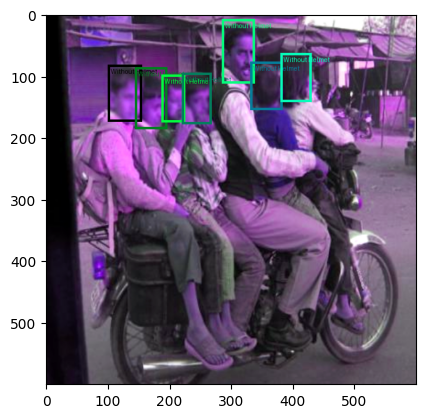

In [69]:
plt.imshow(draw_bounding_boxes(
    img_int, targ['boxes'], [classes[i] for i in targ['labels']], width=4
).permute(1, 2, 0))

In [71]:
class HelmetDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id)) 
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [72]:
train_dataset = HelmetDetection(root=data_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [73]:
len(train_dataset)

1182

Model
Our model is FasterRCNN with a backbone of MobileNetV3-Large. We need to change the output layers because we have just 6 classes but this model was trained on 90 classes.

In [75]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)


Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to C:\Users\lenovo/.cache\torch\hub\checkpoints\fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100.0%


In [ ]:
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [77]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [78]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
images,targets = next(iter(train_loader))

In [ ]:
images = list(image for image in images)

In [ ]:
targets = [{k:v for k, v in t.items()} for t in targets]

In [ ]:
output = model(images, targets) # just make sure this runs without error

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
model = model.to(device)

optimizer

In [1]:
# This line uses a list comprehension to iterate over the model's parameters.
# The if p.requires_grad condition filters out parameters that do not require gradients.
# The resulting list params contains only the parameters that require gradients.

In [ ]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [ ]:
# params: The list of parameters that require gradients.
# lr=0.01: The learning rate, which controls how quickly the model learns from the data.
# momentum=0.9: The momentum term, which helps the optimizer escape local minima.
# nesterov=True: Enables Nesterov acceleration, which modifies the momentum update rule to improve convergence.
# weight_decay=1e-4: The L2 regularization strength, which helps prevent overfitting by penalizing large weights.
# Why Filter Parameters by requires_grad?
# By filtering parameters by requires_grad, you ensure that the optimizer only updates the parameters that are 
# actually being trained. This is important because some parameters, like those in batch normalization layers, may not 
# require gradients.

Training

In [ ]:
import sys

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
# # Looping through Data Loader:

# # The code iterates through batches of data provided by the loader (likely a PyTorch DataLoader).
# # images is a list of tensors representing the batch of images.
# # targets is a list of dictionaries containing labels or other target information associated with each image.
# # Moving Data to Device:

# # images.to(device): Moves the image tensors to the specified device (device), which is either a GPU or CPU depending on your setup.
# # targets: A list comprehension iterates over each target dictionary (t) and converts its values (v) to PyTorch tensors using torch.tensor(v). These tensors are also moved to the device using .to(device).
# # Forward Pass:

# # loss_dict = model(images, targets): This line performs the forward pass through your PyTorch model (model). The model likely takes the images and targets as input and calculates the loss automatically. The output loss_dict is a dictionary containing various loss components.
# # Calculating Total Loss:

# # losses = sum(loss for loss in loss_dict.values()): This line iterates over the values in loss_dict and sums them up to get the total loss for the current batch.
# # Converting Loss Values to Scalars:

# # loss_dict_append = {k: v.item() for k, v in loss_dict.items()}: This creates a new dictionary loss_dict_append by iterating over the original loss_dict. It extracts the scalar values from the tensors in loss_dict using .item() and stores them in the new dictionary. This makes it easier to work with the loss values later.
# # loss_value = losses.item(): Similarly, the total loss (losses) is converted to a scalar using .item().
# # Tracking Losses:

# # all_losses.append(loss_value): The scalar total loss (loss_value) is appended to a list all_losses for later analysis or visualization of the training process.
# # all_losses_dict.append(loss_dict_append): The dictionary containing individual loss components (loss_dict_append) is appended to a list all_losses_dict for potentially more detailed loss analysis.
# # Checking for Non-Finite Loss:

# # if not math.isfinite(loss_value): This check ensures that the loss value is a finite number (not NaN or infinity). If it's not finite, it might indicate a problem with the training process.
# # Error Handling and Stopping Training:

# # If the loss is non-finite, the code prints an error message with the loss value and the loss_dict (which might provide clues about the issue).
# # sys.exit(1): The code exits the program with an error code (1) to indicate an abnormal termination.
# # Backward Pass and Optimization:

# # optimizer.zero_grad(): This line zeros the gradients of the model's parameters

# optimizer.zero_grad():

# Purpose: Before performing the backpropagation step, it's crucial to clear the gradients accumulated in the model's parameters from the previous training iteration.
# Why? If you don't clear the gradients, they will accumulate over multiple training steps, leading to incorrect updates and unstable training.
# losses.backward():

# This line initiates the backpropagation process.
# Backpropagation is an algorithm that calculates the gradients of the loss function with respect to each parameter of the model.
# These gradients indicate how much each parameter should be adjusted to minimize the loss.
# optimizer.step():

# This line performs the optimization step.
# The optimizer (e.g., Adam, SGD) uses the calculated gradients to update the model's parameters.
# The specific update rule depends on the chosen optimizer. For example, Adam typically uses a combination of momentum and adaptive learning rates.
# In essence:

# The model generates predictions, and the loss function calculates the error between the predictions and the ground truth.
# losses.backward() computes how much each parameter in the model contributed to the error.
# optimizer.step() adjusts the model's parameters based on the calculated gradients, aiming to minimize the overall loss.


In [ ]:
num_epochs=1

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = HelmetDetection(root=data_path, split="test", transforms=get_transforms(False))

In [ ]:
len(test_dataset)

In [ ]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda") # use GPU to train

classes = ['vehicles', 'Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

model = torch.load(r"")

model.eval()

img = Image.open(r"")

convert_tensor = transforms.ToTensor()

img1 = convert_tensor(img)

img_int = torch.tensor(img1*255, dtype=torch.uint8)

with torch.no_grad():
    prediction = model([img1.to(device)])
    pred = prediction[0]

bbox_tensor = draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(0, 2, 1)

In [ ]:
bbox_tensor

In [ ]:
# Converting image into base64

import base64
from io import BytesIO

buffered = BytesIO()
img.save(buffered, format="JPEG")
img_str = base64.b64encode(buffered.getvalue())

In [ ]:
img_str

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv("")

In [ ]:

data.head()

In [ ]:
data.describe().mean()

In [ ]:

data.plot()

In [ ]:

model = torch.load(r"")

In [ ]:

model

In [ ]:
model.parameters